In [2]:
import numpy as np
import cv2
import scipy.stats as stats
import mpmath as mp
import matplotlib.pyplot as plt
import seaborn as sns
import skimage


In [3]:
plt.gray()

<Figure size 432x288 with 0 Axes>

In [4]:
def see(img):
    plt.imshow(img)
    plt.show()

# Preprocessing & Features

##  Write a function that reads in the image as well as the mask

In [5]:
def getHSV_Image_and_Mask(img,mask):
    # import images (will be in bgr because of cv2)
    img_bgr = cv2.imread(img)
    mask_bgr = cv2.imread(mask)
    
    # binarise the mask because it contains grey pixels due to interpolation from jpeg compression:
    binary = skimage.filters.threshold_otsu(mask_bgr[:,:,0])
    m = mask_bgr[:,:,0]>binary
    
    # get r,g, and b of img_bgr:
    img_r = img_bgr[:,:,2]
    img_g = img_bgr[:,:,1]
    img_b = img_bgr[:,:,0]
    
    # convert img_bgr to HSV:
    img_hsv = cv2.cvtColor(img_bgr,cv2.COLOR_BGR2HSV)
    
    # get H, S and V of img_hsv
    img_H = img_hsv[:,:,0]
    img_S = img_hsv[:,:,1]
    img_V = img_hsv[:,:,2]
    
    print('r,g,b,h,s,v, mask')
    see(img_r)
    see(img_g)
    see(img_b)
    see(img_H)
    see(img_S)
    see(img_V)
    see(m)
    
    return(img_r,img_g,img_b,img_H,img_S,img_V, m)

r,g,b,h,s,v, mask


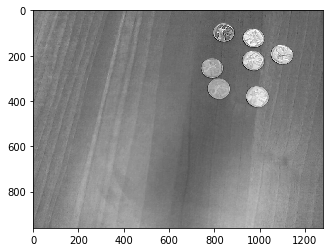

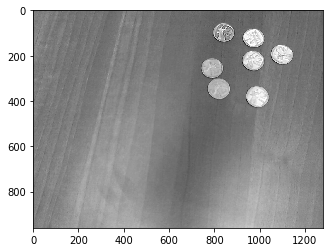

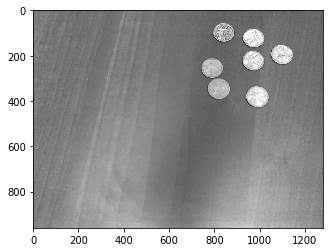

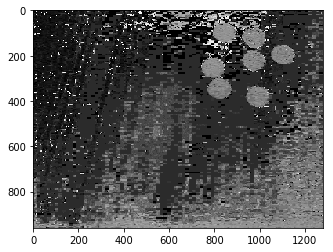

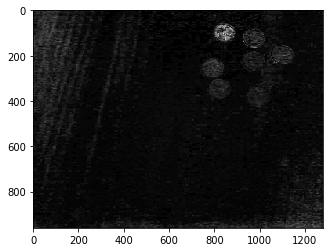

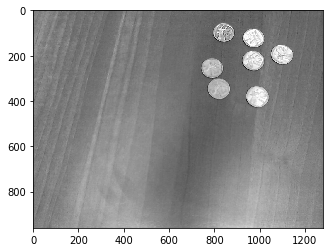

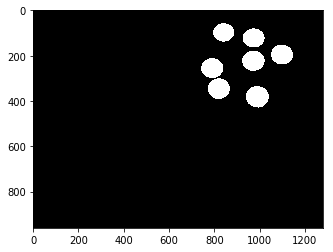

In [5]:
r,g,b,h,s,v, mask = getHSV_Image_and_Mask('coins/train.jpg','coins/mask.jpg')

In [6]:
def extract_coins(img, mask):
#     returns location of pixels in coins, given a mask
#    assumes 255 corresponds to a coin pixel location
    i, j = np.where(mask == True)
    coins=img[i,j]
    return coins

In [7]:
def extract_desk(img, mask):
#     returns location of pixels in coins, given a mask
#    assumes 255 corresponds to a coin pixel location
    i, j = np.where(mask == False)
    desk=img[i,j]
    return desk

### In the sections that follow, we are going to make use of the Value (Lightness/Brightness) of the pixel – making the assumption that the coins are shinier than the desk and will thus be brighter.

# Task: Fitting a Normal Distribution

In [8]:
# coin data

data1 = extract_coins(r,mask)
data2 = extract_coins(g,mask)
data3 = extract_coins(b,mask)
data4 = extract_coins(h,mask)
data5 = extract_coins(s,mask)
data6 = extract_coins(v,mask)

# desk data

desk1 = extract_desk(r,mask)
desk2 = extract_desk(g,mask)
desk3 = extract_desk(b,mask)
desk4 = extract_desk(h,mask)
desk5 = extract_desk(s,mask)
desk6 = extract_desk(v,mask)

# Fit Normal, ML

#### The likelihood P r(x 1...I |μ, σ 2 ) of the parameters {μ, σ 2 } for observed data {x i } Ii=1 is computed by evaluating the pdf for each data point separately and taking the product:

For univariate normal, the ML parameters are just mean and variance

In [9]:
cμ = np.mean(data1)
cσ = np.var(data1)

dμ = np.mean(desk1)
dσ = np.var(desk1)
print('dσ,dμ,cμ,cσ:',dσ,dμ,cμ,cσ)

dσ,dμ,cμ,cσ: 307.44330720510584 135.92963871939608 186.58575365698536 1298.1300323607693


In [68]:
# test
cσ1 = (np.sum((data1-cμ)**2))
cσ1  

61232793.62645748

# Get test data

r,g,b,h,s,v, mask


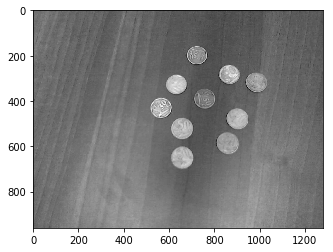

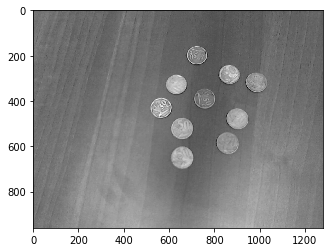

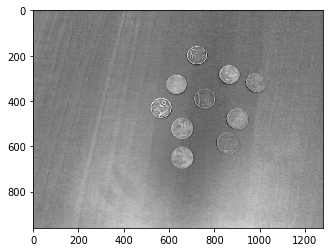

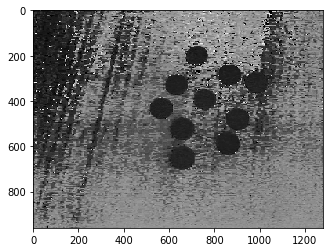

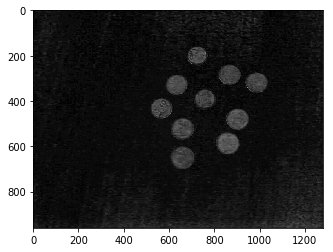

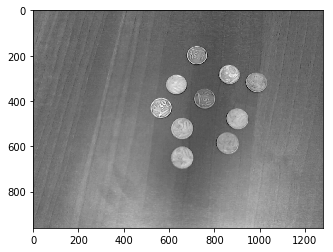

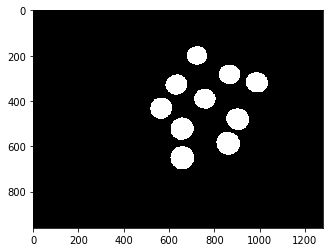

In [10]:
test1r,test1g,test1b,test1h,test1s,test1v,test1mask = getHSV_Image_and_Mask('coins/val1.jpg','coins/val_mask1.png')

# make the distributions using the ML parameters:

In [11]:
#  stats.norm.pdf(x , mu, sigma) produces array holding a pdf mapped from x to  Norm_x(mu, sigm^2)


# coin distribution:

coin_dist = stats.norm.pdf(test1r, cμ, np.sqrt(cσ) )

# desk distribution

desk_dist = stats.norm.pdf(test1r, dμ, np.sqrt(dσ) )

# Classify based on this stupid random formula (like the book but without Pr(w)):

 ## Pr(w|x) = Pr(x|w) / ΣPr(x|wi) > 0.5

In [12]:
def Stupid_formula(coin_dist, desk_dist):
    Pr_coin = coin_dist/ (desk_dist + coin_dist)
    
    return Pr_coin

In [13]:
teepa =Stupid_formula(coin_dist,desk_dist)
# teepa # test

In [14]:
def stupid_classify(Pr_coin):
    return np.greater(Pr_coin, 0.5)

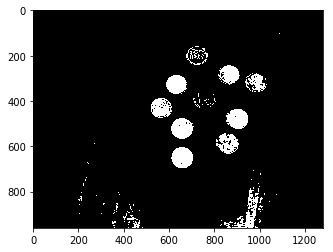

In [15]:
nala = stupid_classify(teepa)
see(nala)

# Make a formula so we can test this on all other channels quickly

In [8]:
def train_channel(train_image, train_mask, channel, pixels=100, method='ML',α1=1, β1=1,γ1=1, δ1=0, 
                  α2=1, β2=1,γ2=1, δ2=0):
#    '''
#     args:
     
#         train_image: (String). Path to image file to be used for training the model.
                
#         train_mask: (String). Path to mask image file corresponding to train_image, 
#                     to be used for training the model.
        

#         channel: (String). Which channel to train on.
#                 'r'
#                 'g'
#                 'b'
#                 'h'
#                 's'
#                 'v'


#         pixels: number of pixels to train on as percentage of image. 
#                 e.g 25 := train on 25% of the pixels from the training image


#         method: (String). Method for getting model parameters.
#                 'ML' := max likelihood, 
#                 'MAP' := max a posterior,
#                 'B' := Bayesian
                
                
#         Returns model parameters to be used in fitting a test image (see test_channel()).
#     '''

    # get channels from test_image:
    r,g,b,h,s,v, mask = getHSV_Image_and_Mask(train_image, train_mask)
    
    
    # seperate coins in each channel:
    # coin data
    data1 = extract_coins(r,mask)[:int(0.01*pixels*r.size)]
    data2 = extract_coins(g,mask)[:int(0.01*pixels*r.size)]
    data3 = extract_coins(b,mask)[:int(0.01*pixels*r.size)]
    data4 = extract_coins(h,mask)[:int(0.01*pixels*r.size)]
    data5 = extract_coins(s,mask)[:int(0.01*pixels*r.size)]
    data6 = extract_coins(v,mask)[:int(0.01*pixels*r.size)]
    
    # desk data
    desk1 = extract_desk(r,mask)[:int(0.01*pixels*r.size)]
    desk2 = extract_desk(g,mask)[:int(0.01*pixels*r.size)]
    desk3 = extract_desk(b,mask)[:int(0.01*pixels*r.size)]
    desk4 = extract_desk(h,mask)[:int(0.01*pixels*r.size)]
    desk5 = extract_desk(s,mask)[:int(0.01*pixels*r.size)]
    desk6 = extract_desk(v,mask)[:int(0.01*pixels*r.size)]
    

#     Use user-specified channel:
    if(channel=='r'):
        data = data1
        desk = desk1
    elif(channel == 'g'):
        data = data2
        desk = desk2
    elif(channel == 'b'):
        data = data3
        desk = desk3
    elif(channel == 'h'):
        data = data4
        desk = desk4
    elif(channel == 's'):
        data = data5
        desk = desk5
    elif(channel == 'v'):
        data = data6
        desk = desk6
        

    
    
    # Get model parameters using the user-specified method:
    # This is currently assuming a normal distribution for the model and NormalInverseGamma as prior.
    if(method=='ML'):
        cμ = np.mean(data)
        cσ = np.var(data)

        dμ = np.mean(desk)
        dσ = np.var(desk)
        print('dσ,dμ,cμ,cσ:',dσ,dμ,cμ,cσ)
        return dσ,dμ,cμ,cσ
    elif(method=='MAP'):
        cμ = (data.size*np.mean(data) + γ1*δ1) / (data.size + γ1)
        dμ = (desk.size*np.mean(desk) + γ2*δ2) / (desk.size + γ2)
        
        cσ = ( (np.sum((data-cμ)**2)) + 2*β1 + γ1*(δ1-cμ)**2 ) / (data.size + 3 + 2*α1)
        dσ = ( (np.sum((desk-dμ)**2)) + 2*β2 + γ2*(δ2-dμ)**2 ) / (desk.size + 3 + 2*α2)
        print('dσ,dμ,cμ,cσ:',dσ,dμ,cμ,cσ)
        return dσ,dμ,cμ,cσ
    elif(method=='B'):
        αt1 = α1 + 0.5*data.size
        βt1 = 0.5*(np.sum(data**2)) + β1 + (0.5*γ1*(δ1**2)) - ( (γ1*δ1 + np.sum(data))**2 / (2*(γ1+data.size)) )
        γt1 = γ1 + data.size
        δt1 = (γ1*δ1 + np.sum(data)) / (γ1+data.size)
        
        αt2 = α2 + 0.5*desk.size
        βt2 = 0.5*(np.sum(desk**2)) + β2 + (0.5*γ2*(δ2**2)) - ( (γ2*δ2 + np.sum(desk))**2 / (2*(γ2+desk.size)) )
        γt2 = γ2 + desk.size
        δt2 = (γ2*δ2 + np.sum(desk)) / (γ2+desk.size)
        
        return αt1,βt1,γt1,δt1,αt2,βt2,γt2,δt2
    
    
    
    
    return 0
    
    
    

In [160]:
(0.01*100*r.size)

1228800.0

In [9]:
# only works with normal params for now
def test_channel(test_image, test_mask, channel, method, dσ=None,dμ=None,cμ=None,cσ=None, 
                αt1=None,βt1=None,γt1=None,δt1=None,αt2=None,βt2=None,γt2=None,δt2=None):
    
    '''
        Returns an array with true where a coin pixel has been classified
    '''
    
    
#     ---------------------------- Helper functions ------------------------
    def Stupid_formula(coin_dist, desk_dist):
        print(coin_dist.shape, desk_dist.shape)
        Pr_coin = coin_dist/ (desk_dist + coin_dist)
        return Pr_coin

    def stupid_classify(Pr_coin):
        return np.greater(Pr_coin, 0.5)
    
    def accuracy(test, mask):
        return (np.sum(test == mask)/(test.size))*100
        
    # the dumbest thing ever
    powvector = np.frompyfunc(mp.power, 2, 1)
    realvector = np.frompyfunc(mp.re,1,1)
    
#     ----------------------------------------------------------------------------




    # get channels from test_image:
    r,g,b,h,s,v, mask = getHSV_Image_and_Mask(test_image, test_mask)
    
#     print('mask',mask)
    
    # seperate coins in each channel:
    # coin data
    data1 = r
    data2 = g
    data3 = b
    data4 = h
    data5 = s
    data6 = v
    

    

#     Use user-specified channel:
    if(channel=='r'):
        data = data1
    elif(channel == 'g'):
        data = data2
    elif(channel == 'b'):
        data = data3
    elif(channel == 'h'):
        data = data4
    elif(channel == 's'):
        data = data5
    elif(channel == 'v'):
        data = data6
    
    
    
    
    # Get predicitive density using parameters generated by the user-specified method:
    # This is currently assuming a normal distribution for the model and NormalInverseGamma as prior.
    
    if(method=='ML'):
        #  stats.norm.pdf(x , mu, sigma) produces array holding a pdf mapped from x to  Norm_x(mu, sigm^2)
        # coin distribution:
        coin_dist = stats.norm.pdf(data, cμ, np.sqrt(cσ) )
        # desk distribution
        desk_dist = stats.norm.pdf(data, dμ, np.sqrt(dσ) )
        
        teepa =Stupid_formula(coin_dist,desk_dist)
        nala = stupid_classify(teepa)
        see(nala)
        accuracy = accuracy(nala, mask)

        print("Accuracy:",accuracy,"%")
        return nala, accuracy
    
    elif(method=='MAP'):
        #  stats.norm.pdf(x , mu, sigma) produces array holding a pdf mapped from x to  Norm_x(mu, sigm^2)
        # coin distribution:
        coin_dist = stats.norm.pdf(data, cμ, np.sqrt(cσ) )
        # desk distribution
        desk_dist = stats.norm.pdf(data, dμ, np.sqrt(dσ) )
        
        teepa =Stupid_formula(coin_dist,desk_dist)
        nala = stupid_classify(teepa)
        see(nala)
        accuracy = accuracy(nala, mask)

        print("Accuracy:",accuracy,"%")
        return nala, accuracy
    
    elif(method=='B'):
        
        αc1 = αt1 + 0.5
        βc1 = 0.5*(data**2) + βt1 + 0.5*(γt1*(δt1**2)) -  0.5*(((γt1*δt1 + data)**2) / (γt1 + 1))
        γc1 = γt1 + 1
        
        αc2 = αt2 + 0.5
        βc2 = 0.5*(data**2) + βt2 + 0.5*(γt2*(δt2**2)) -  0.5*(((γt2*δt2 + data)**2) / (γt2 + 1))
        γc2 = γt2 + 1
        
        k1 = (   1/(np.sqrt(2*pi))  )
        k2 = ( (np.sqrt(γt1)*(mp.power(βt1,αt1)))/(np.sqrt(γc1)*(powvector(βc1,αc1))) )
        k3 = ( (mp.gamma(αc1)) / (mp.gamma(αt1)) )
        κc1 =  k1 * k2 * k3
    
    
        kk1 = (   1/(np.sqrt(2*pi))  )
        kk2 = ( (np.sqrt(γt2)*(mp.power(βt2,αt2)))/(np.sqrt(γc2)*(powvector(βc2,αc2))) )
        kk3 = ( (mp.gamma(αc2)) / (mp.gamma(αt2)) )
        κc2 =  kk1 * kk2 * kk3
    
        teepa = realvector(Stupid_formula(κc1,κc2))
        nala = stupid_classify(teepa)
        print("Nala:")
        see(nala)
        accuracy = accuracy(nala, mask)
        print("Accuracy:",accuracy,"%")

#         print("kappa coins, kappa desk:",κc1,κc2)
        return nala, accuracy
    


r,g,b,h,s,v, mask


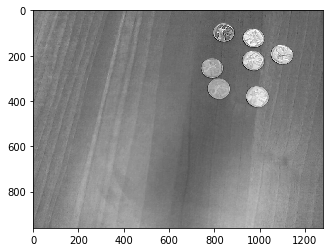

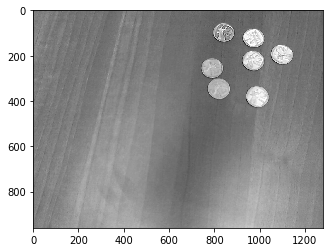

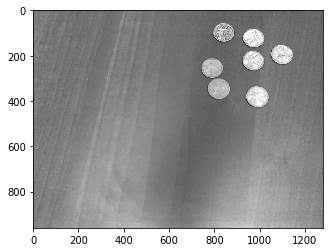

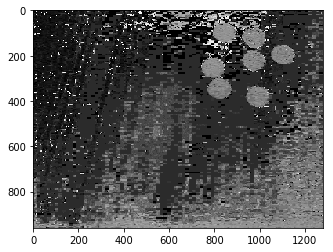

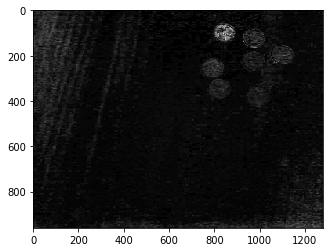

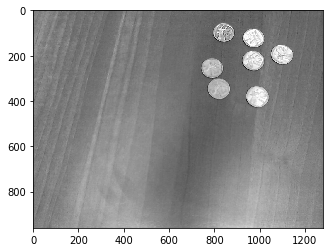

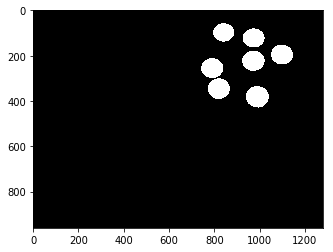

dσ,dμ,cμ,cσ: 337.18742140288947 137.2046224283405 202.11602713589144 1235.6543138326324


In [14]:
# αt1,βt1,γt1,δt1,αt2,βt2,γt2,δt2= train_channel('coins/train.jpg','coins/mask.jpg', 'r', 1,'MAP' )
dσ,dμ,cμ,cσ = train_channel('coins/train.jpg','coins/mask.jpg', 'v',100,'ML' )

r,g,b,h,s,v, mask


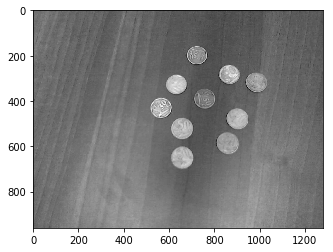

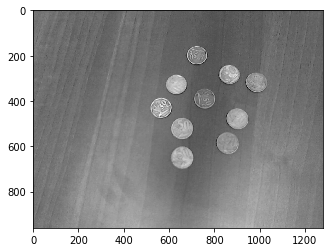

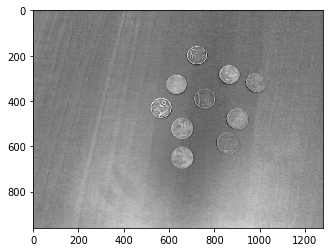

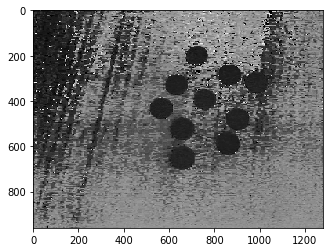

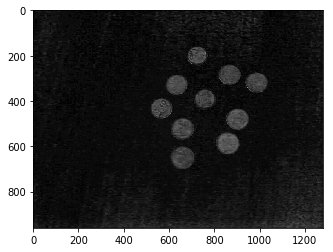

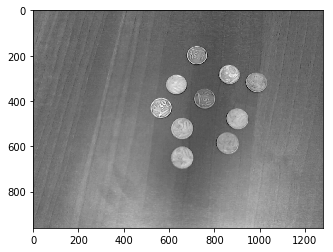

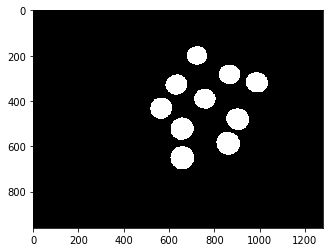

(960, 1280) (960, 1280)


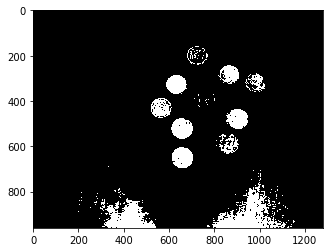

Accuracy: 94.1318359375 %


In [15]:
# teepa1 = test_channel('coins/val1.jpg','coins/val_mask1.png','r','MAP',0,0,0,0,αt1,βt1,γt1,δt1,αt2,βt2,γt2,δt2)
teepa1 = test_channel('coins/val1.jpg','coins/val_mask1.png','v','ML',dσ,dμ,cμ,cσ)

In [171]:
teepa1

# try with other test image:

r,g,b,h,s,v, mask


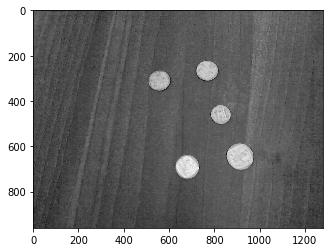

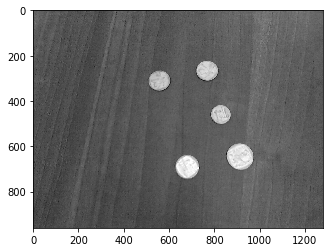

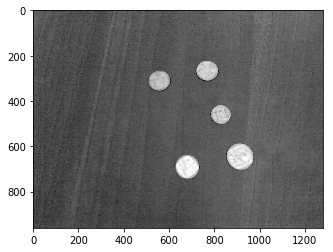

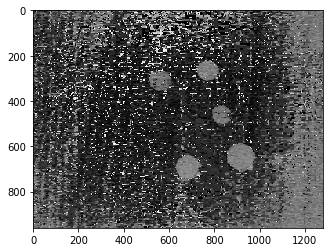

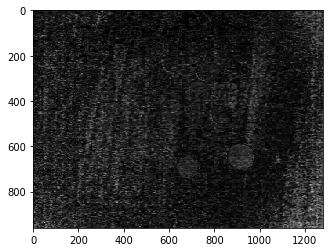

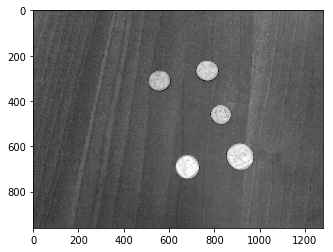

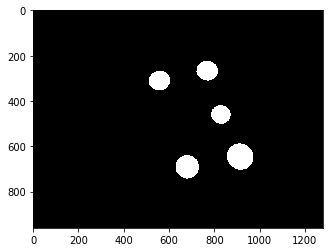

(960, 1280) (960, 1280)


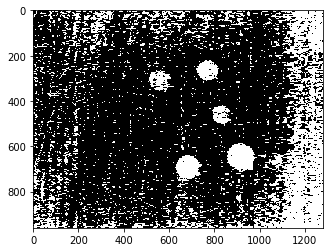

Accuracy: 77.8984375 %


In [84]:
teepa2 = test_channel('coins/val2.jpg','coins/val_mask2.png','h', dσ,dμ,cμ,cσ)